# Proyecto: Descifrando Mensajes Codificados Usando MCMC

Integrantes: Sebastián Flores y Matías Neto

## Procesamiento de la fuente de texto

In [2]:
%pip install pycipher

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 KB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pycipher: filename=pycipher-0.5.2-py3-none-any.whl size=30456 sha256=9de64c40398958bad39dd55ec22b4d2f7946c1fe5d214d3fe7fe9420b2d0b1ac
  Stored in directory: /home/sflores/.cache/pip/wheels/ca/e7/37/bf758675337f9b98f096d8f7a5fd0cf320aadd67ae8a12f545
Successfully built pycipher
You should consider upgrading via the '/home/sflores/anaconda3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
import re
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycipher import SimpleSubstitution


In [2]:
# Cargar el texto
with open("gloria_benitoperezgaldos.txt", "r") as f:
    text = f.readlines()

for i in range(len(text)):
    text[i] = text[i].replace('\n', '')

text = ' '.join(text)

In [3]:
# Sólo minúsculas
clean_text = text.casefold()

# Eliminar tildes
tilde_dict = {'á':'a', 'é': 'e', 'í': 'i', 'ó':'o', 'ú':'u', 'ñ': 'n'}
for key, value in tilde_dict.items():
    clean_text = clean_text.replace(key, value)

# Eliminar caracteres especiales
clean_text = re.sub(r"[^a-zA-Z ]", "", clean_text)
clean_text = clean_text.upper()

In [4]:
def process(word, matrix):
    '''
    Almacena la frecuencia de transiciones de una palabra en una matriz
    
    Argumentos:
        word (string): Palabra a procesar
        matrix (pd.DataFrame): Matriz de transición
    
    Retorna:
        matrix (pd.DataFrame): Matriz de transición actualizada con
                               la palabra procesada
    '''
    letters = list(word)
    matrix.loc[' ', letters[0]] = matrix.loc[' ', letters[0]] + 1
    for i in range(len(word)-1):
        matrix.loc[letters[i], letters[i+1]] = matrix.loc[letters[i], letters[i+1]] + 1
    matrix.loc[letters[len(word)-1], ' '] = matrix.loc[letters[len(word)-1], ' '] + 1
    return matrix

In [5]:
# Creación de la matriz
alphabet = sorted(''.join(set(clean_text)))
matrix = pd.DataFrame(data=np.zeros((len(alphabet), len(alphabet))), index=alphabet, columns=alphabet)
words = clean_text.split()

# Se demora unos minutos
for word in words:
    matrix = process(word, matrix)
transition = matrix.apply(lambda x: x/np.sum(x), axis=1)

## Definición de funciones auxiliares para la minimización

In [66]:
def plausibility(ciphertext, key, matrix = transition):
    '''
    Función de plausibilidad que tiene el rol de -U para SA
    
    Argumentos:
        ciphertext (string): Texto codificado
        key (string): Clave del mismo largo que el alfabeto a testear
        matrix (pd.DataFrame): Matriz de transición construida antes
    
    Retorna:
        plausibility (float): valor de la plausibilidad para key
    '''
    cipher = SimpleSubstitution(key)
    plaintext = cipher.decipher(ciphertext, keep_punct = True)
    words = plaintext.split()
    matrix = pd.DataFrame(data=np.zeros((len(alphabet), len(alphabet))), index=alphabet, columns=alphabet)
    for word in words:
        matrix = process(word, matrix)
    plausibility = np.product((1 + transition.to_numpy()) ** (1 + matrix.to_numpy()))
    return np.log(plausibility)

# Ejemplo
plaintext = "MUCHOS ANOS DESPUES FRENTE AL PELOTON DE FUSILAMIENTO " + \
            "EL CORONEL AURELIANO BUENDIA RECORDO AQUELLA TARDE REMOTA " + \
            "EN QUE SU PADRE LO LLEVO A CONOCER EL HIELO"
real_key = "AJPCZWRLFBDKOTYUQGENHXMIVS"
real_cipher = SimpleSubstitution(real_key)
ciphertext = real_cipher.encipher(plaintext, keep_punct = True)
print(f"Texto cifrado: {ciphertext}")
print(f"Plausibilidad: {plausibility(ciphertext, real_key)}")

Texto cifrado: OHPLYE ATYE CZEUHZE WGZTNZ AK UZKYNYT CZ WHEFKAOFZTNY ZK PYGYTZK AHGZKFATY JHZTCFA GZPYGCY AQHZKKA NAGCZ GZOYNA ZT QHZ EH UACGZ KY KKZXY A PYTYPZG ZK LFZKY
Plausibilidad: 47.44776747911044


In [57]:
# Ejemplo para ver que efectivamente la plausibilidad es menor
example_key = ''.join(random.sample(real_key, len(real_key)))
print("Clave ejemplo: " + example_key)
example_cipher = SimpleSubstitution(example_key)
print("Texto descifrado con la clave: "+example_cipher.decipher(ciphertext, keep_punct=True))
print(f"Plausibilidad: {plausibility(ciphertext, example_key)}")

Clave ejemplo: KAFGZCMNHJSWDQBRYXLEUIOPVT
Texto descifrado con la clave: WIXSQT BZQT FETUIET LDEZHE BA UEAQHQZ FE LITCABWCEZHQ EA XQDQZEA BIDEACBZQ JIEZFCB DEXQDFQ BNIEAAB HBDFE DEWQHB EZ NIE TI UBFDE AQ AAERQ B XQZQXED EA SCEAQ
Plausibilidad: 33.456961934589145


In [74]:
def neighbor(key):
    '''
    Retorna un vecino aleatorio (con distribución uniforme) de la clave
    
    Argumentos:
        key (str): Clave representada por una permutación del alfabeto
    
    Retorna:
        new_key (str): Clave vecina a key
    '''
    indices = random.sample(list(np.arange(len(key))), 2)
    symbol_a, symbol_b = key[indices[0]], key[indices[1]]
    new_key = list(key)
    new_key[indices[0]] = symbol_b
    new_key[indices[1]] = symbol_a
    new_key = ''.join(new_key)
    return new_key

nghbr = neighbor(example_key)
print(f"Clave ejemplo: {example_key}")
print(f"Vecino: {nghbr}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if example_key[i] != nghbr[i]]}")

Clave ejemplo: KAFGZCMNHJSWDQBRYXLEUIOPVT
Vecino: GAFKZCMNHJSWDQBRYXLEUIOPVT
Indices intercambiados: [0, 3]


In [70]:
''.join(sorted(list(real_key)))

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

## Optimización

In [60]:
def SADecipher(ciphertext: str, Niter: int, beta,
               initial_key = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ',
               print_period = None):
    '''
    Función que implementa Simmulated Annealing 
    para el problema de descifrado
    
    Argumentos:
        ciphertext: Código a descifrar
        Niter: Número de pasos a realizar
        beta (fun): Función que representa el beta del método de SA
        initial_key (str): una clave inicial para el algoritmo
        print_period: Representa el periodo de actualización. 
            Si no es None, se imprime el estado de la cadena
            y la plausibilidad cada print_period pasos
    
    Retorna:
        key: Estado de la cadena luego de Niter pasos
    '''
    
    U = np.random.uniform(0, 1, size = Niter)
    key = initial_key
    incumbent_plaus = plausibility(ciphertext, key)
    scores = np.zeros(Niter)
    if print_period == None:
        for i in range(Niter):
            scores[i] = incumbent_plaus
            new_key = neighbor(key)
            new_plaus = plausibility(ciphertext, new_key)
            if U[i] <= np.exp(beta(i) * (new_plaus - incumbent_plaus)):
                key = new_key
                incumbent_plaus = new_plaus
    else:
        for i in range(Niter):
            scores[i] = incumbent_plaus
            new_key = neighbor(key)
            new_plaus = plausibility(ciphertext, new_key)
            if U[i] <= np.exp(beta(i) * (new_plaus - incumbent_plaus)):
                key = new_key
                incumbent_plaus = new_plaus
            if i % print_period == 0:
                cipher = SimpleSubstitution(key)
                print(f"Paso {i}")
                print(f"Frase actual: {cipher.decipher(ciphertext, keep_punct = True)}")
                print(f"Plausibilidad: {incumbent_plaus}")
    return key, scores

# Test de SADecipher
beta = lambda x: 1     
sample_advance, sample_scores = SADecipher(ciphertext, 10, beta)
print(f"Estado de la cadena luego de 10 pasos con beta = 1: {sample_advance}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'[i] != sample_advance[i]]}")

Estado de la cadena luego de 10 pasos con beta = 1: APCOEFNGTJKLMHBDIRSQUVWZYX
Indices intercambiados: [1, 3, 6, 7, 8, 13, 14, 15, 16, 19, 23, 25]


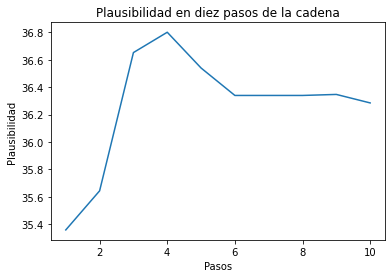

In [61]:
def graph_scores(scores, Niter, title):
    plt.figure()
    plt.plot(np.arange(Niter) + 1, scores)
    plt.title(title)
    plt.xlabel("Pasos")
    plt.ylabel("Plausibilidad")
    plt.show()
    return 

graph_scores(sample_scores, 10, "Plausibilidad en diez pasos de la cadena")

Paso 0
Frase actual: OHPNYE ATYE CZEUHZE WGZTLZ AK UZKYLYT CZ WHEFKAOFZTLY ZK PYGYTZK AHGZKFATY JHZTCFA GZPYGCY AQHZKKA LAGCZ GZOYLA ZT QHZ EH UACGZ KY KKZXY A PYTYPZG ZK NFZKY
Plausibilidad: 35.66793662482362
Paso 1000
Frase actual: FKVWNC QUNC ODCXKDC MHDULD QY XDYNLNU OD MKCIYQFIDULN DY VNHNUDY QKHDYIQUN JKDUOIQ HDVNHON QEKDYYQ LQHOD HDFNLQ DU EKD CK XQOHD YN YYDTN Q VNUNVDH DY WIDYN
Plausibilidad: 33.77144844060628
Paso 2000
Frase actual: QIMHAK LRAK EOKVIOK DCORTO LY VOYATAR EO DIKGYLQGORTA OY MACAROY LICOYGLRA BIOREGL COMACEA LXIOYYL TLCEO COQATL OR XIO KI VLECO YA YYOUA L MARAMOC OY HGOYA
Plausibilidad: 42.46537476734463
Paso 3000
Frase actual: JUHPAN YRAN VENXUEN GDERLE YS XESALAR VE GUNOSYJOERLA ES HADARES YUDESOYRA CUERVOY DEHADVA YQUESSY LYDVE DEJALY ER QUE NU XYVDE SA SSEMA Y HARAHED ES POESA
Plausibilidad: 46.790203613021625
Paso 4000
Frase actual: LUMHAK OSAK TEKPUEK FDESZE OY PEYAZAS TE FUKIYOLIESZA EY MADASEY OUDEYIOSA CUESTIO DEMADTA OQUEYYO ZODTE DELAZO ES QUE KU POTD

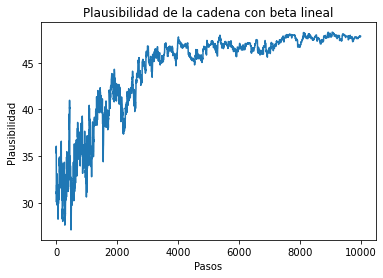

In [62]:
beta = lambda x: 10**(-3) * x
Niter = 10000
beta_lineal, scores_lineal = SADecipher(ciphertext, Niter, beta, print_period = 1000)
print(f"Estado de la cadena luego de 10 pasos con beta lineal: {sample_advance}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'[i] != sample_advance[i]]}")
graph_scores(scores_lineal, Niter, "Plausibilidad de la cadena con beta lineal")

Paso 0
Frase actual: OHPLYE ATYE CZEUHZE XGZTNZ AK UZKYNYT CZ XHEFKAOFZTNY ZK PYGYTZK AHGZKFATY JHZTCFA GZPYGCY AQHZKKA NAGCZ GZOYNA ZT QHZ EH UACGZ KY KKZWY A PYTYPZG ZK LFZKY
Plausibilidad: 35.37616047725922
Paso 1000
Frase actual: FOQACN LVCN ZGNIOGN TXGVJG LW IGWCJCV ZG TONBWLFBGVJC GW QCXCVGW LOXGWBLVC UOGVZBL XGQCXZC LHOGWWL JLXZG XGFCJL GV HOG NO ILZXG WC WWGRC L QCVCQGX GW ABGWC
Plausibilidad: 29.886776210638025
Paso 2000
Frase actual: WVAIBS TRBS NYSPVYS OKYRLY TU PYUBLBR NY OVSFUTWFYRLB YU ABKBRYU TVKYUFTRB ZVYRNFT KYABKNB TMVYUUT LTKNY KYWBLT YR MVY SV PTNKY UB UUYGB T ABRBAYK YU IFYUB
Plausibilidad: 32.5529743994809
Paso 3000
Frase actual: PIHBAY XOAY TEYLIEY FVEOZE XS LESAZAO TE FIYDSXPDEOZA ES HAVAOES XIVESDXOA RIEOTDX VEHAVTA XGIESSX ZXVTE VEPAZX EO GIE YI LXTVE SA SSEMA X HAOAHEV ES BDESA
Plausibilidad: 41.343528916747545
Paso 4000
Frase actual: BTDUIE YRIE POECTOE FVORGO YA COAIGIR PO FTESAYBSORGI OA DIVIROA YTVOASYRI MTORPSY VODIVPI YXTOAAY GYVPO VOBIGY OR XTO ET CYPV

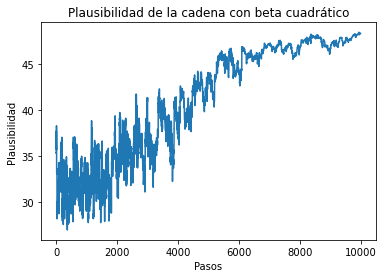

In [76]:
beta = lambda x: 10**(-7) * x ** 2
Niter = 10000
beta_quad, scores_quad = SADecipher(ciphertext, Niter, beta, print_period = 1000)
print(f"Estado de la cadena luego de 10 pasos con beta lineal: {sample_advance}")
print(f"Indices intercambiados: {[i for i in range(len(example_key)) if 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'[i] != sample_advance[i]]}")
graph_scores(scores_quad, Niter, "Plausibilidad de la cadena con beta cuadrático")